Aluno: Leonam Rezende Soares de Miranda

Para observar que o MLP é capaz de aproximar qualquer função contínua, deve ser realizada a regressão de um ciclo de uma senoide com backpropagation. A função de ativação da camada de saída deve ser
linear, e a camada escondida deve ser composta de 3 neurônios. 

O conjunto de treinamento deve ser constituído de 45 amostras com valores de $x$ amostrados entre $0$ e
$2\pi$ e valores de $𝑦 = sen(𝑥) + 𝑟𝑢í𝑑𝑜$. O ruído deve ser uniformemente amostrado no intervalo $[-0.1, 0.1]$.
O conjunto de teste deve ser composto de valores de 𝑥 entre entre 0 e 2𝜋, obtidos com passo 𝛿 = 0.01, e
𝑦 = 𝑠𝑒𝑛𝑜(𝑥).

In [182]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y

In [112]:
# Conjunto de treinamento - 45 pontos uniformimente amostrados entre 0 e 2pi
X_train = np.random.uniform(0, 2*math.pi, 45)

# Avaliação do conjunto de treinamento
# sen(x) + ruido uniformemente amostrado no intervalo [-0.1,0.1].
Y_train = np.sin(X_train) + np.random.uniform(-0.1, 0.1, 45)

In [113]:
# Conjunto de teste - Valores entre 0 e 2pi com passo igual a 0.01
X_test = np.arange(0, 2*math.pi, 0.01)
Y_test = np.sin(X_test)

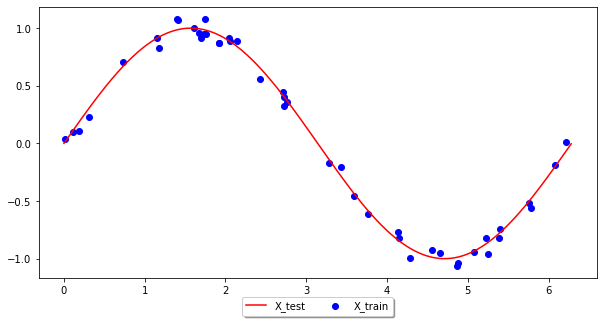

In [114]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.scatter(X_train, Y_train,  c='blue', label='X_train')
ax.plot(X_test, Y_test, c='red', label='X_test')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

In [214]:
class MLP(BaseEstimator, RegressorMixin):
    """ Classificador MLP de 2 camadas"""

    def __init__(self, n_h = 3, classificator = True, learning_rate=0.01, maxepocas = 2000, tol = 0.005, print_cost = False):
        
        # size of the input layer
        self.n_x = None     
        # size of the hidden layer
        self.n_h = n_h
        # size of the output layer
        self.n_y = None
        
        self.parameters = {}
        self.cache = {}
        self.grads = {}

        # Se for um classificador
        self.classificator = classificator
        # taxa de aprendizado
        self.learning_rate = learning_rate
        self.maxepocas = maxepocas
        self.tol = tol
        self.print_cost = print_cost

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""

        if self.classificator:
            assert set(y) == {-1, 1}, 'Response variable must be ±1'

        if X.shape == (X.shape[0],):
            X = np.reshape(X, (X.shape[0],1))

        if y.shape == (y.shape[0],):
            y = np.reshape(y, (y.shape[0],1))

        check_X_y(X, np.ravel(y))

        return X, y

    def __initialize_parameters(self, X, y):
        self.n_x = X.shape[1]
        self.n_y = y.shape[1]
        W1 = np.random.randn(self.n_x, self.n_h) * 0.01
        b1 = np.zeros(shape=(1, self.n_h))
        W2 = np.random.randn(self.n_h, self.n_y) * 0.01
        b2 = np.zeros(shape=(1, self.n_y))
        self.parameters = {"W1": W1,
                           "b1": b1,
                           "W2": W2,
                           "b2": b2}
        self.eta = self.learning_rate
        return self
    
    def __forward_propagation(self, X):
        """
        Argument:
        X -- input data of size (n_x, m)
        
        """
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        
        # Implement Forward Propagation
        Z1 = np.dot(X, W1) + b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        if self.classificator:
            A2 = np.tanh(Z2)
        else:
            A2 = Z2
        
        assert(A2.shape[0] == X.shape[0])
        
        self.cache = {"Z1": Z1,
                      "A1": A1,
                      "Z2": Z2,
                      "A2": A2}

        return A2

    def __compute_cost(self, A2, Y):
        """
        Computes the mean squared error (MSE)
        
        Arguments:
        Y -- "true" labels vector of shape (1, number of examples)
        
        Returns:
        cost -- mean squared error
        """
        
        cost = np.average(np.power(A2 - Y, 2))
        
        cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
        assert(isinstance(cost, float))
        
        return cost

    def __backward_propagation(self, X, Y):
        """
        Implement the backward propagation using the instructions above.
        
        Arguments:
        X -- input data of shape (2, number of examples)
        Y -- "true" labels vector of shape (1, number of examples)

        """
        m = X.shape[0]
        
        # Retrieve W2 from the dictionary "parameters"
        W2 = self.parameters['W2']

        # Retrieve also A1 and A2 from dictionary "cache".
        A1 = self.cache['A1']
        A2 = self.cache['A2']

        # Backward propagation: calculate dW1, db1, dW2, db2. 
        if self.classificator:
            dZ2 = np.multiply(A2 - Y, 1 - np.power(A2, 2))
        else: 
            dZ2 = (A2 - Y)

        dW2 = (1 / m) * np.dot(A1.T, dZ2)
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)

        dZ1 = np.multiply(np.dot(dZ2, W2.T), 1 - np.power(A1, 2))
        dW1 = (1 / m) * np.dot(X.T, dZ1)
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

        self.grads = {"dW1": dW1,
                      "db1": db1,
                      "dW2": dW2,
                      "db2": db2}
        
        return self

    def __update_parameters(self):
        """
        Updates parameters using the gradient descent update rule given above
        
        """
        # Retrieve each parameter from the dictionary "parameters"
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
    
        # Retrieve each gradient from the dictionary "grads"
        dW1 = self.grads['dW1']
        db1 = self.grads['db1']
        dW2 = self.grads['dW2']
        db2 = self.grads['db2']

        # Update rule for each parameter
        W1 = W1 - self.eta * dW1
        b1 = b1 - self.eta * db1
        W2 = W2 - self.eta * dW2
        b2 = b2 - self.eta * db2

        self.parameters = {"W1": W1,
                           "b1": b1,
                           "W2": W2,
                           "b2": b2}

        return self

    def fit(self, X: np.ndarray, Y: np.ndarray):
        """Controi um classificador otimizado a partir do conjunto de treinamento (X, y).
         Parâmetros
         ----------
         X: {tipo matriz, matriz esparsa} de forma (n_amostras, n_características)
             Os exemplos de entrada de treinamento.
         y: Vetor de formato (n_samples,)
             Os valores alvo (rótulos de classe) do conjunto de treinamento.

         Retorna
         -------
         self: objeto
             Estimador ajustado.
         """
        # Valida os rótulos
        X, Y = self._check_X_y(X, Y)
        N = X.shape[0]

        # Inicializa parametros
        self.__initialize_parameters(X, Y)

        nepocas = 0
        cost = []


        while nepocas < self.maxepocas:    
            xseq = random.sample(range(N), N)
            for i in range(N):
                irand = xseq[i]
                xatual = X[irand,:]
                yatual = Y[irand,:]

                # Forward propagation. Inputs: "X". Outputs: "A2".
                A2 = self.__forward_propagation(xatual)
    
                # Backpropagation. Inputs: "X, Y"
                self.__backward_propagation(xatual, yatual)
    
                # Gradient descent parameter update.
                self.__update_parameters()
            
            # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
            A2 = self.__forward_propagation(X)

            # Cost function. Inputs: "A2, Y". Outputs: "cost".
            cost.append(self.__compute_cost(A2, Y))

            if cost[nepocas] < self.tol:
                break

            # Readjust the learning rate every 1000 iterations
            if i % 1000 == 0:
                self.eta  = self.learning_rate * (self.maxepocas-i)/self.maxepocas
                if self.print_cost:
                   print ("Cost after iteration %i: %f" % (i, cost[i]))

            nepocas+=1

        if self.print_cost:
            print ("Cost after fitting the model: %f" % (cost[-1]))
            plt.plot(cost[0:i])
            plt.xlabel('Época')
            plt.ylabel('Custo')
            plt.show()

        return self

    def predict(self, X):
        """ Make predictions using already fitted model
        Parâmetros
         ----------
        X: {tipo matriz, matriz esparsa} de forma (n_amostras, n_características)
             Os exemplos de entrada.
        """
        if X.shape == (X.shape[0],):
            X = np.reshape(X, (X.shape[0],1))
        return self.__forward_propagation(X)

    def score(self, X, Y):
        """ Retorna a acurácia do classificador ou MSE caso seja feita regressão
        Parâmetros
         ----------
        X: {tipo matriz, matriz esparsa} de forma (n_amostras, n_características)
             Os exemplos de entrada.
        Y: Vetor de formato (n_samples,)
             Os valores alvo (rótulos de classe) dos exemplos de entrada.
        """
        if Y.shape == (Y.shape[0],):
            Y = np.reshape(Y, (Y.shape[0],1))

        Y_pred = self.predict(X)

        if self.classificator:
            return np.average(Y_pred == Y)
        else:
            return -self.__compute_cost(Y_pred, Y)
        return

Devem ser executadas 5 inicializações diferentes da rede MLP e, para cada uma, deve ser calculado o erro quadrático médio (MSE). Ao final das 5 execuções, devem ser apresentados a média e o desvio-padrão dos valores de MSE. Para uma das execuções, deve ser gerado um gráfico comparando a saída da função aproximada e os valores esperados de 𝑦. 

Cost after fitting the model: 0.003848


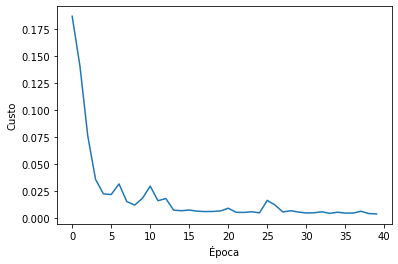

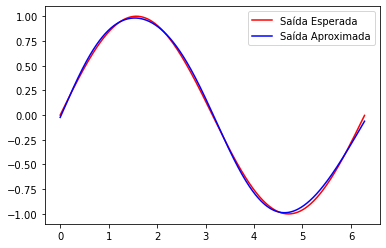

In [209]:
model = MLP(classificator=False, print_cost=True)
model.fit(X_train, Y_train)
custo = (-1) * model.score(X_train, Y_train)

Y_pred = model.predict(X_test)
plt.plot(X_test, Y_test, c='red')
plt.plot(X_test, Y_pred, c='blue')
plt.legend(['Saída Esperada', 'Saída Aproximada'], loc ="upper right")
plt.show()

Np código a seguir foram feitas 5 inicializações diferentes da rede MLP e, para cada uma, foi calculado o erro quadrático médio (MSE), apresentando ao final a média e o desvio padrão.

In [216]:
custos = []

for _ in range(5):

    model = MLP(classificator=False)
    model.fit(X_train, Y_train)
    custos.append((-1) * model.score(X_test, Y_test))

print('Custo médio obtido: ' + str(np.round(np.mean(custo),6)) + ' +/- ' + str(np.round(np.std(custo),6)))

Custo médio obtido: 0.003848 +/- 0.0
